# Statistical Analysis of Algorithm Performance

This notebook performs statistical analysis to compare the performance of 8 algorithms on 2 datasets, with 10 runs per algorithm. The analysis includes:
- Friedman test for non-parametric comparison
- Nemenyi post-hoc test
- Visualization through boxplots, critical difference diagrams, and heatmaps

In [1]:
# Import required libraries
import pandas as pd
import importlib
import numpy as np
from scipy import stats
from scikit_posthocs import posthoc_nemenyi_friedman
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for better visualization
sns.set_theme(style="whitegrid")

## Helper Functions

Define functions for statistical analysis and visualization

In [2]:
def perform_friedman_test(data):
    """Perform Friedman test on the data"""
    statistic, p_value = stats.friedmanchisquare(*[data[col] for col in data.columns])
    return statistic, p_value

def create_boxplot(data, title):
    """Create a boxplot for algorithm comparison"""
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=data)
    plt.title(title)
    plt.xticks(rotation=45)
    plt.ylabel('Performance')
    plt.tight_layout()
    return plt.gcf()

def create_cd_diagram(data, algorithm_names, title):
    """Create Critical Difference diagram without using Orange library"""
    # Calculate average rank
    ranks = data.rank(axis=1)
    avg_ranks = ranks.mean()

    # Calculate critical difference
    num_algorithms = len(algorithm_names)
    num_datasets = len(data)
    q = 3.25  # for alpha=0.05
    cd = q * np.sqrt(num_datasets * (num_datasets + 1) / (6.0 * num_algorithms))
    print(f'CD = {cd}')

    # Plot diagram using sns
    plt.figure(figsize=(12, 9))
    sns.barplot(x=avg_ranks, y=algorithm_names, hue=algorithm_names, palette='viridis', dodge=False, legend=False)
    plt.axvline(x=cd, color='red', linestyle='--')
    # set xticks
    plt.xticks(np.arange(0, 10, 1))
    # set no outer box
    sns.despine(offset=10, trim=True, left=True)
    # set x-axis limit
    plt.title(title)
    plt.xlabel('Average Rank', fontsize=14)
    plt.ylabel('', fontsize=14)
    ## set title font size
    plt.title(title, fontsize=16)
    # set labels font size
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    # set no grid
    plt.grid(False)

    plt.tight_layout()
    return plt.gcf()  # Return the figure object

def create_heatmap(post_hoc_results, algorithm_names, title):
    """Create triangular heatmap for post-hoc test results with different colors indicating significance levels"""
    plt.figure(figsize=(12, 9))

    # Create a mask for the upper triangle
    mask = np.triu(np.ones_like(post_hoc_results, dtype=bool))

    # Define a custom color map
    cmap = sns.diverging_palette(220, 20, as_cmap=True)

    # Create the heatmap
    heatmap = sns.heatmap(post_hoc_results,
                          xticklabels=algorithm_names,
                          yticklabels=algorithm_names,
                          cmap='viridis',
                          center=0.05,
                          annot=True,
                          annot_kws={"size": 14},
                          mask=mask,
                          cbar_kws={"label": "p-value"})

    plt.title(title, fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid(False)
    plt.tight_layout()
    return plt.gcf()

def acreate_heatmap(post_hoc_results, algorithm_names, title):
    """Create heatmap for post-hoc test results"""
    plt.figure(figsize=(12, 9))
    # Create a triangular  heatmap with different colors indicating p-values above 0.05 (no significant difference),
    # below 0.05 (significant difference), 0.01 (highly significant difference), and 0.001 (very highly significant difference)
    heatmap = sns.heatmap(post_hoc_results,
                          xticklabels=algorithm_names,
                          yticklabels=algorithm_names,
                          cmap='viridis',
                          center=0.05,
                          annot=True, annot_kws={"size": 14})

    # mask = np.triu(np.ones_like(post_hoc_results, dtype=bool))
    # heatmap = sns.heatmap(post_hoc_results,
    #                         xticklabels=algorithm_names,
    #                         yticklabels=algorithm_names,
    #                         cmap='viridis',
    #                         center=0.05,
    #                         annot=True, annot_kws={"size": 14},
    #                         mask=mask)
    plt.title(title, fontsize=16)
    # add labels
    #plt.xlabel('Algorithm')
    #plt.ylabel('Algorithm')
    # add label to the color bar
    cbar = heatmap.collections[0].colorbar
    #cbar.set_label('p-value')
    # set labels font size
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    # set font size for the color bar
    cbar.ax.tick_params(labelsize=12)
    # set title font size
    cbar.ax.set_title('p-value', fontsize=16)
    # set values font size
    for t in cbar.ax.yaxis.get_ticklabels():
        t.set_fontsize(12)
    plt.grid(False)
    plt.tight_layout()
    return plt.gcf()

## Load and Prepare Data

Load the datasets from CSV files

In [3]:
# Load datasets
dataset_penn = pd.read_csv('Penn TreeBank.csv', sep=';')
dataset_wiki = pd.read_csv('WikiText.csv', sep=';')

# Display first few rows of each dataset
print("Dataset 1 head:")
display(dataset_penn.head())
print("\nDataset 2 head:")
display(dataset_wiki.head())

Dataset 1 head:


,FNet (96),FNet (128),LSTM (96),LSTM (128),Tranformer (96),Tranformer (128),Quixer (5 qubits),Quixer (6 qubits),Quixer (7 qubits)
0,119.040450,117.201617,190.773125,177.101756,99.692397,96.463902,123.128482,118.944444,116.321170
1,119.463680,117.923038,196.829187,179.615180,99.816340,96.705450,124.594288,119.301432,116.888978
2,120.067208,118.058831,199.215375,183.398315,99.843753,96.894458,124.867618,119.565327,116.988925
3,120.277806,118.070069,199.713123,184.415647,99.849993,97.101437,124.892803,119.907262,117.411014
4,120.333041,118.148427,200.814134,184.638818,99.906330,97.124837,125.456686,120.044609,117.442994



Dataset 2 head:


,FNet (96),FNet (128),LSTM (96),LSTM (128),Tranformer (96),Tranformer (128),Quixer (5 qubits),Quixer (6 qubits),Quixer (7 qubits)
0,157.739300,154.534328,257.637610,232.967738,137.330267,132.975043,190.289084,180.556299,173.323759
1,163.079695,155.896697,260.995394,233.369802,137.816603,133.204799,191.918825,181.232787,173.911237
2,163.355733,156.066402,261.451069,235.460434,137.820561,133.397298,192.352264,182.006916,174.824668
3,163.441514,157.067880,262.188005,237.217524,138.072189,133.403178,192.782397,185.461636,175.168438
4,163.771798,157.763233,265.801466,237.894583,138.223084,133.469363,193.405464,187.166909,175.540312


## Statistical Analysis

Perform analysis for each dataset


Analysis for Penn TreeBank

Best (minimum) values:


FNet (96)            119.040450
FNet (128)           117.201617
LSTM (96)            190.773125
LSTM (128)           177.101756
Tranformer (96)       99.692397
Tranformer (128)      96.463902
Quixer (5 qubits)    123.128482
Quixer (6 qubits)    118.944444
Quixer (7 qubits)    116.321170
dtype: float64


Best performing algorithm:
Tranformer (128) (mean: 97.1227)

Friedman Test Results:
Statistic: 78.4800
P-value: 0.0000

Significant differences found. Performing post-hoc analysis...

Nemenyi Post-hoc Test Results:


,FNet (96),FNet (128),LSTM (96),LSTM (128),Tranformer (96),Tranformer (128),Quixer (5 qubits),Quixer (6 qubits),Quixer (7 qubits)
FNet (96),1.000000,0.951282,7.959736e-02,4.574319e-01,1.224029e-01,9.919393e-03,0.929810,1.000000,0.684806
FNet (128),0.951282,1.000000,1.042992e-03,2.310987e-02,8.309581e-01,3.017818e-01,0.216887,0.929810,0.999730
LSTM (96),0.079597,0.001043,1.000000e+00,9.964245e-01,3.919157e-07,2.334776e-09,0.786726,0.099179,0.000076
LSTM (128),0.457432,0.023110,9.964245e-01,1.000000e+00,3.389951e-05,3.919157e-07,0.996425,0.514231,0.002868
Tranformer (96),0.122403,0.830958,3.919157e-07,3.389951e-05,1.000000e+00,9.964245e-01,0.001472,0.099179,0.987742
Tranformer (128),0.009919,0.301782,2.334776e-09,3.919157e-07,9.964245e-01,1.000000e+00,0.000034,0.007361,0.684806
Quixer (5 qubits),0.929810,0.216887,7.867263e-01,9.964245e-01,1.472234e-03,3.389951e-05,1.000000,0.951282,0.049858
Quixer (6 qubits),1.000000,0.929810,9.917872e-02,5.142314e-01,9.917872e-02,7.360695e-03,0.951282,1.000000,0.629121
Quixer (7 qubits),0.684806,0.999730,7.625684e-05,2.868055e-03,9.877420e-01,6.848059e-01,0.049858,0.629121,1.000000



Generating visualizations...


<Figure size 640x480 with 0 Axes>

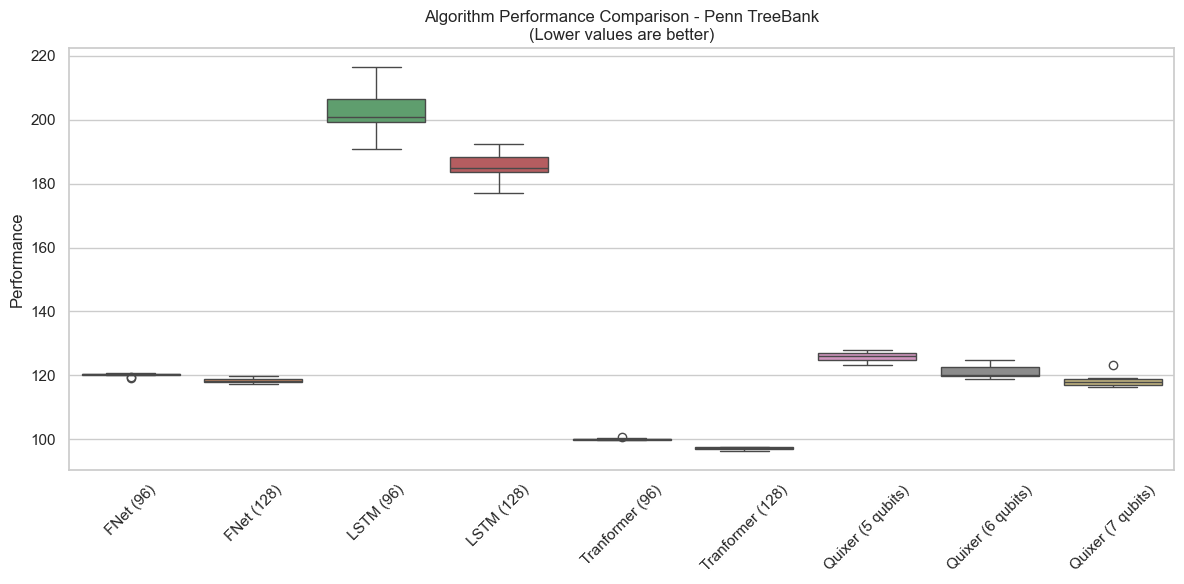

CD = 4.638556208962409


<Figure size 640x480 with 0 Axes>

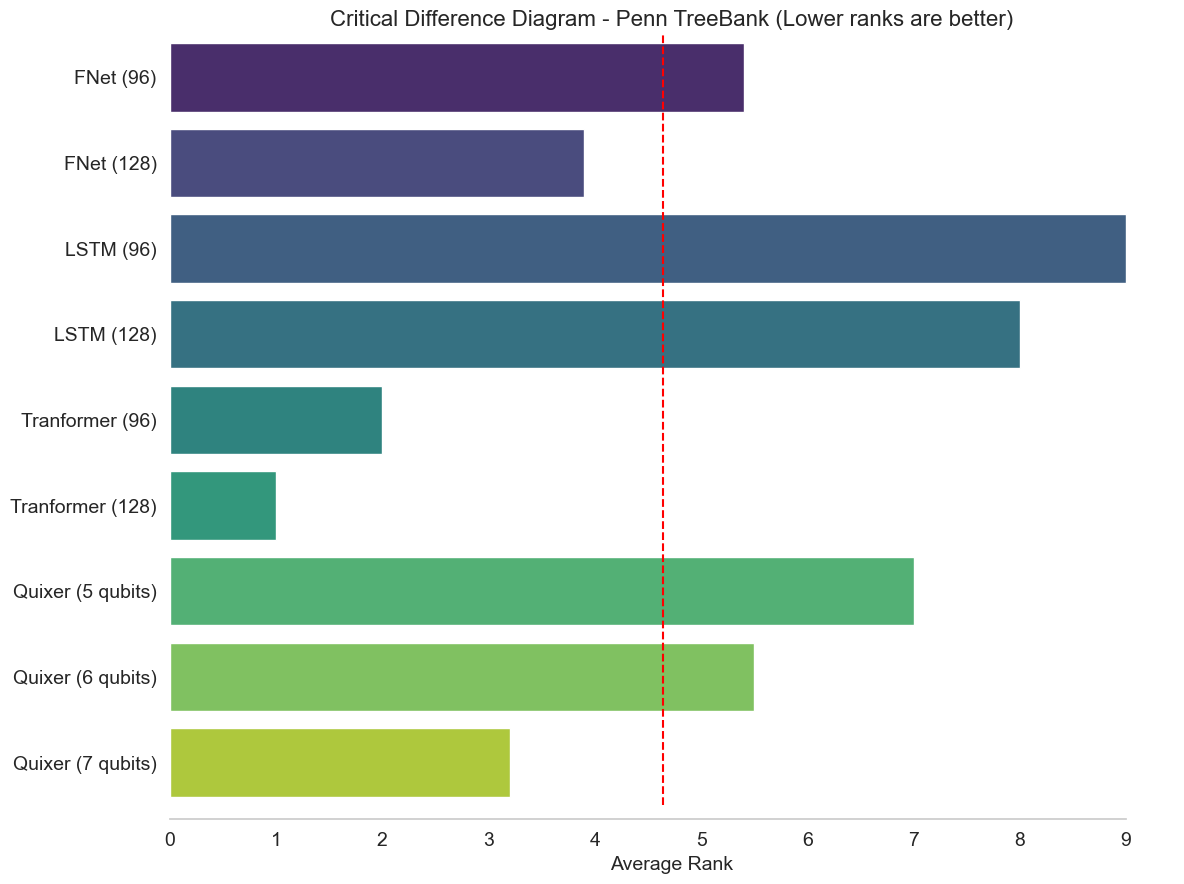

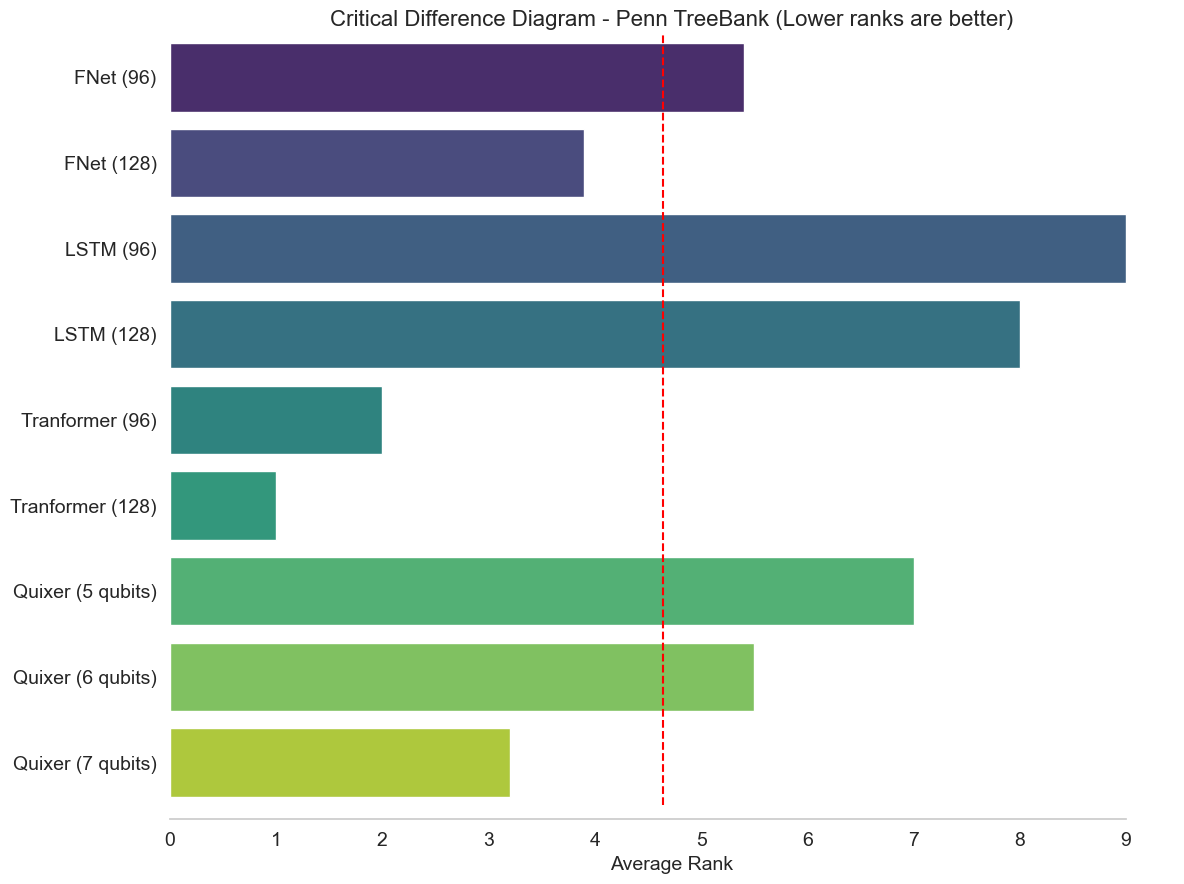

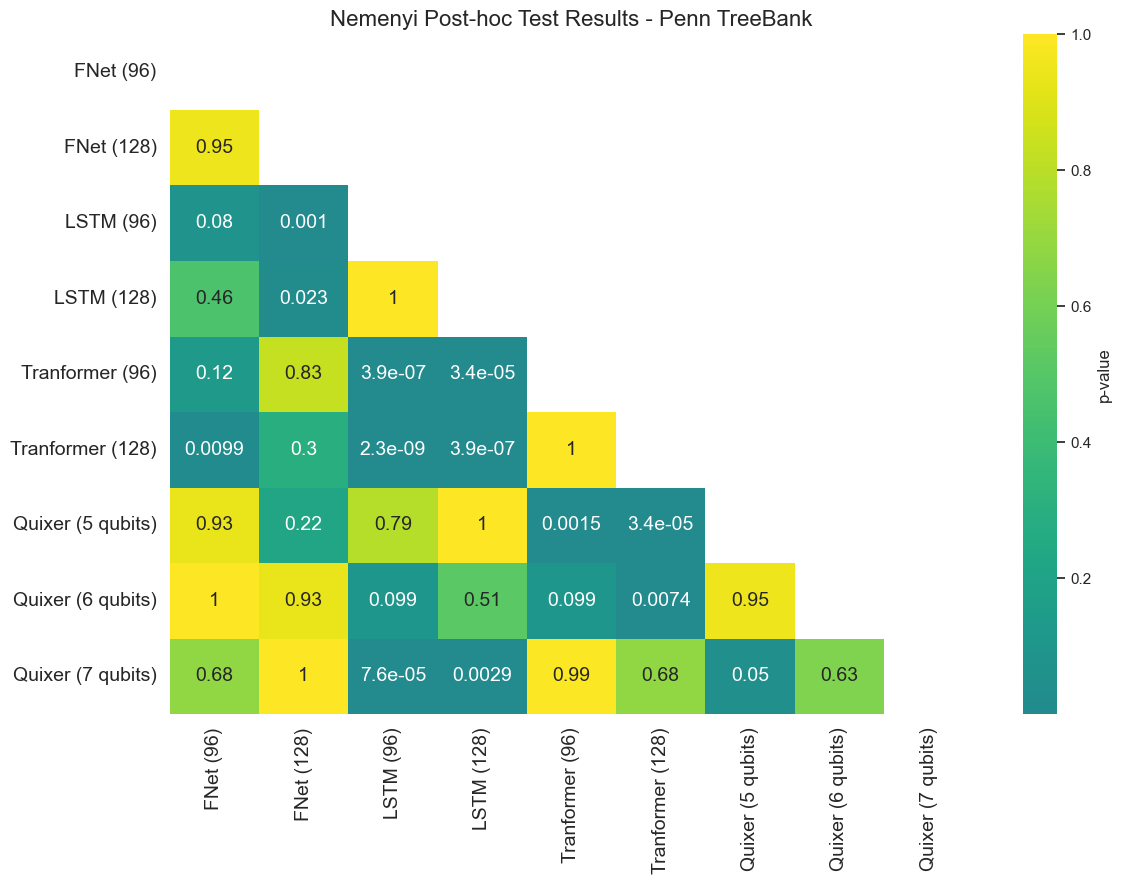


Analysis for WikiText

Best (minimum) values:


FNet (96)            157.739300
FNet (128)           154.534328
LSTM (96)            257.637610
LSTM (128)           232.967738
Tranformer (96)      137.330267
Tranformer (128)     132.975043
Quixer (5 qubits)    190.289084
Quixer (6 qubits)    180.556299
Quixer (7 qubits)    173.323759
dtype: float64


Best performing algorithm:
Tranformer (128) (mean: 133.7014)

Friedman Test Results:
Statistic: 79.7600
P-value: 0.0000

Significant differences found. Performing post-hoc analysis...

Nemenyi Post-hoc Test Results:


,FNet (96),FNet (128),LSTM (96),LSTM (128),Tranformer (96),Tranformer (128),Quixer (5 qubits),Quixer (6 qubits),Quixer (7 qubits)
FNet (96),1.000000,0.996425,1.472234e-03,3.012352e-02,7.867263e-01,2.571750e-01,0.301782,0.737706,0.996425
FNet (128),0.996425,1.000000,3.389951e-05,1.472234e-03,9.964245e-01,7.867263e-01,0.038926,0.216887,0.786726
LSTM (96),0.001472,0.000034,1.000000e+00,9.964245e-01,3.919157e-07,2.334776e-09,0.737706,0.301782,0.030124
LSTM (128),0.030124,0.001472,9.964245e-01,1.000000e+00,3.389951e-05,3.919157e-07,0.993125,0.830958,0.257175
Tranformer (96),0.786726,0.996425,3.919157e-07,3.389951e-05,1.000000e+00,9.964245e-01,0.002063,0.023110,0.257175
Tranformer (128),0.257175,0.786726,2.334776e-09,3.919157e-07,9.964245e-01,1.000000e+00,0.000051,0.001043,0.030124
Quixer (5 qubits),0.301782,0.038926,7.377056e-01,9.931248e-01,2.062649e-03,5.101931e-05,1.000000,0.999276,0.830958
Quixer (6 qubits),0.737706,0.216887,3.017818e-01,8.309581e-01,2.310987e-02,1.042992e-03,0.999276,1.000000,0.993125
Quixer (7 qubits),0.996425,0.786726,3.012352e-02,2.571750e-01,2.571750e-01,3.012352e-02,0.830958,0.993125,1.000000



Generating visualizations...


<Figure size 640x480 with 0 Axes>

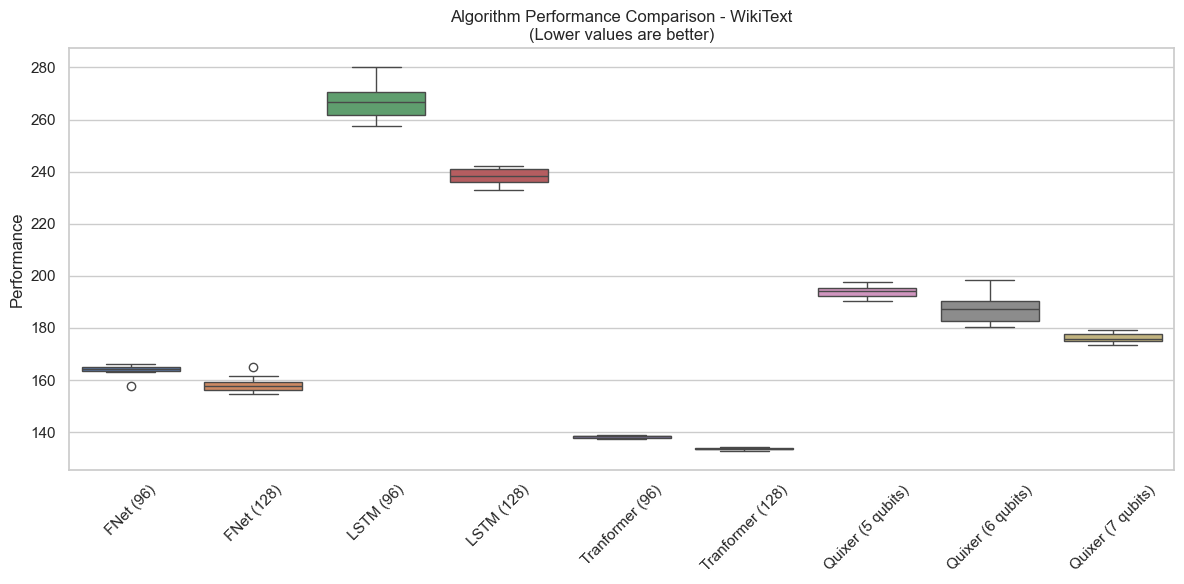

CD = 4.638556208962409


<Figure size 640x480 with 0 Axes>

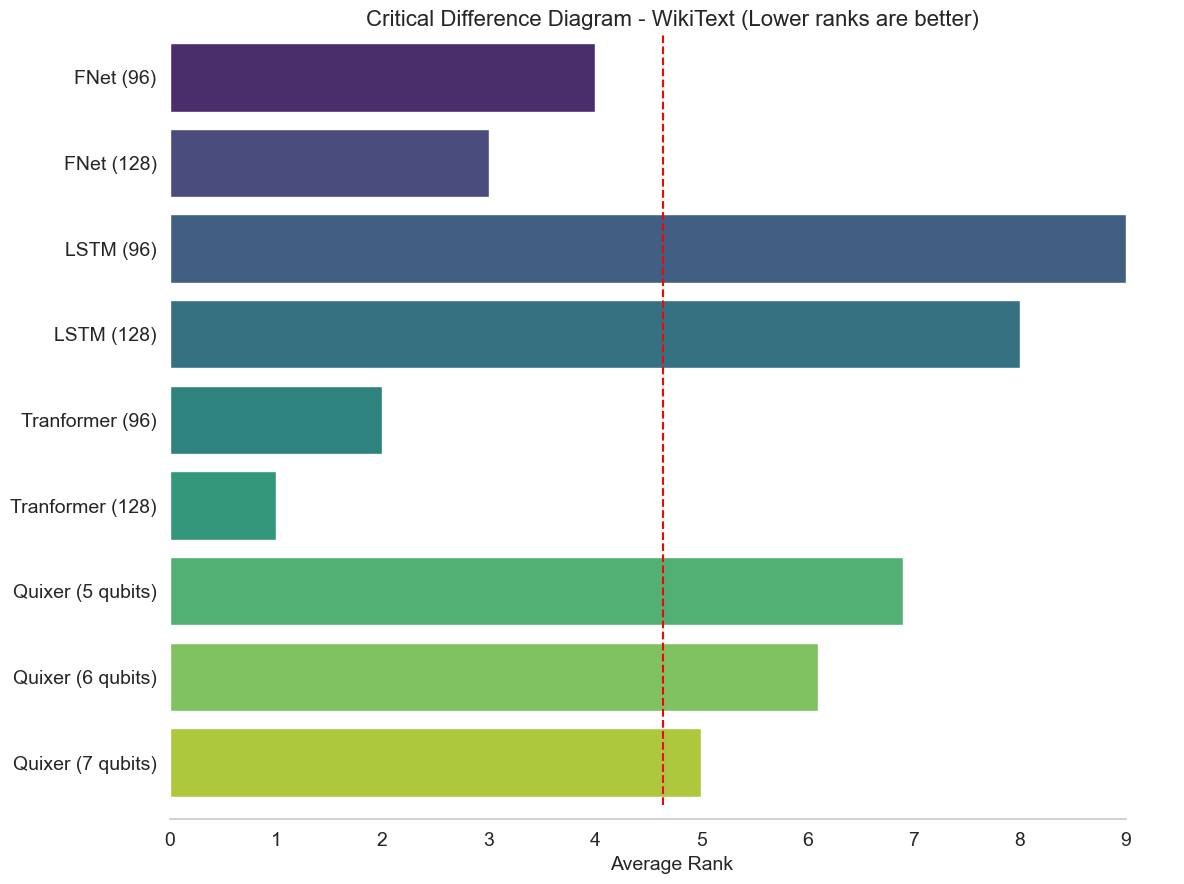

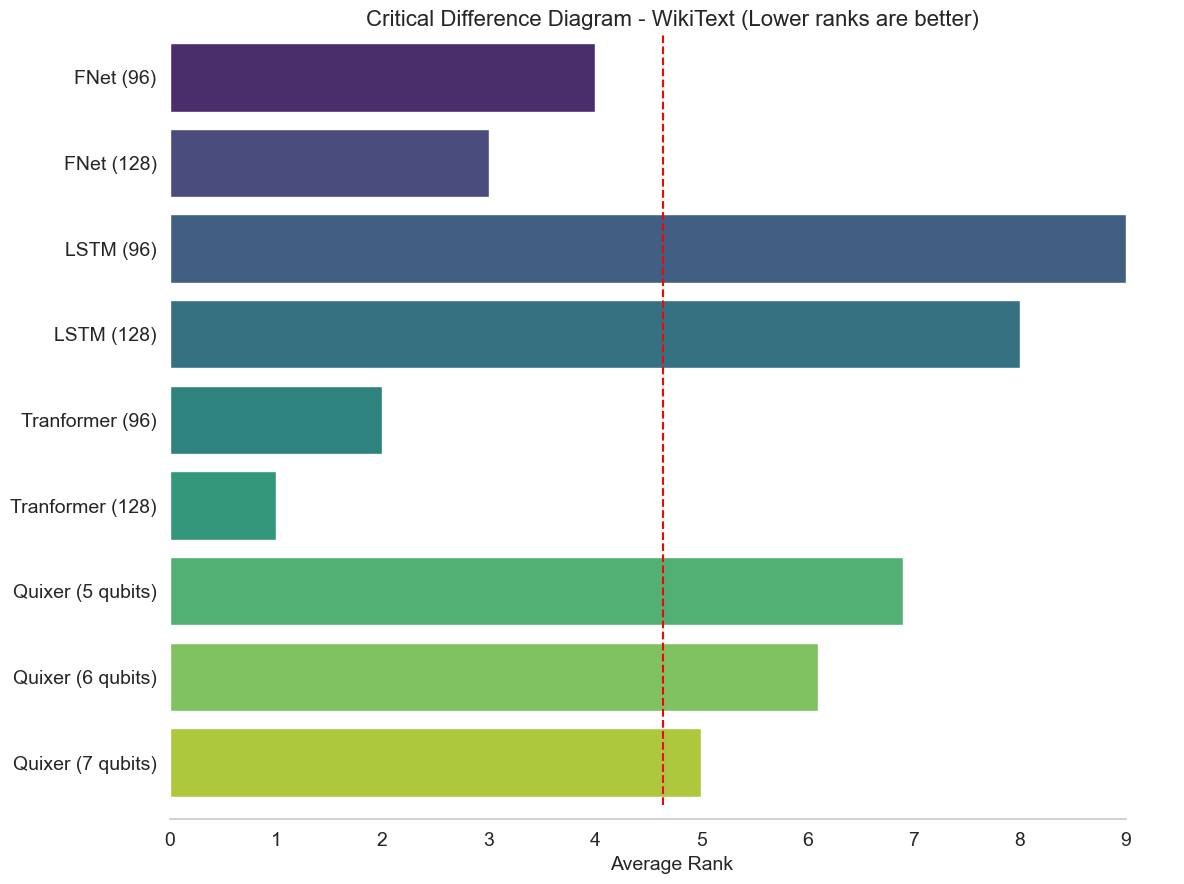

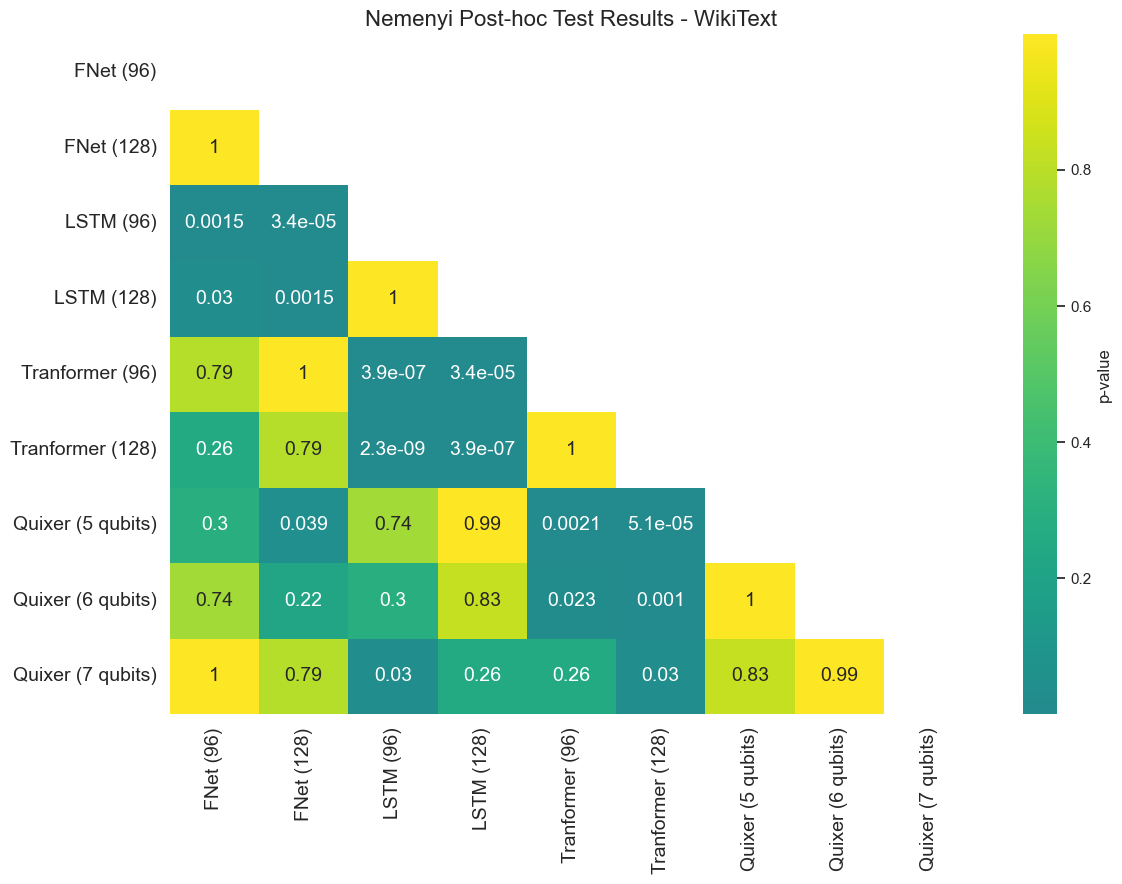

In [4]:
def analyze_dataset(dataset, dataset_name):
    print(f"\nAnalysis for {dataset_name}")
    print("="*50)

    # Basic statistics for minimization problem
    print("\nBest (minimum) values:")
    best_values = dataset.min()
    display(best_values)

    print("\nBest performing algorithm:")
    best_algo = dataset.mean().idxmin()
    print(f"{best_algo} (mean: {dataset[best_algo].mean():.4f})")

    # Friedman test
    statistic, p_value = perform_friedman_test(dataset)
    print(f"\nFriedman Test Results:")
    print(f"Statistic: {statistic:.4f}")
    print(f"P-value: {p_value:.4f}")

    if p_value < 0.05:
        print("\nSignificant differences found. Performing post-hoc analysis...")

        # Nemenyi post-hoc test
        post_hoc_results = posthoc_nemenyi_friedman(dataset)
        print("\nNemenyi Post-hoc Test Results:")
        display(post_hoc_results)

        # Create visualizations
        print("\nGenerating visualizations...")

        # 1. Boxplot
        plt.figure()
        boxplot = create_boxplot(dataset, f"Algorithm Performance Comparison - {dataset_name}\n(Lower values are better)")
        plt.show()
        # 2. Critical Difference diagram
        plt.figure()
        cd_diagram = create_cd_diagram(dataset, dataset.columns, f"Critical Difference Diagram - {dataset_name} (Lower ranks are better)")
        cd_diagram.savefig(f"CD-Diagram-{dataset_name}.png", dpi=300, bbox_inches='tight')  # Save the figure
        plt.show()
        # 3. Post-hoc test heatmap
        plt.figure(cd_diagram)
        heatmap = create_heatmap(post_hoc_results, dataset.columns, f"Nemenyi Post-hoc Test Results - {dataset_name}")
        heatmap.savefig(f"Heatmap-{dataset_name}.png", dpi=300, bbox_inches='tight')  # Save the figure
        plt.show()
    else:
        print("\nNo significant differences found between algorithms.")

        # Create boxplot anyway for visualization
        plt.figure()
        boxplot = create_boxplot(dataset, f"Algorithm Performance Comparison - {dataset_name}\n(Lower values are better)")
        plt.show()

# Analyze both datasets
analyze_dataset(dataset_penn, 'Penn TreeBank')
analyze_dataset(dataset_wiki, 'WikiText')

## Results Summary

Create a summary table comparing results across both datasets


Analysis for Penn TreeBank

Best (minimum) values:


FNet (96)            119.040450
FNet (128)           117.201617
LSTM (96)            190.773125
LSTM (128)           177.101756
Tranformer (96)       99.692397
Tranformer (128)      96.463902
Quixer (5 qubits)    123.128482
Quixer (6 qubits)    118.944444
Quixer (7 qubits)    116.321170
dtype: float64


Best performing algorithm:
Tranformer (128) (mean: 97.1227)

Friedman Test Results:
Statistic: 78.4800
P-value: 0.0000

Significant differences found. Performing post-hoc analysis...

Nemenyi Post-hoc Test Results:


,FNet (96),FNet (128),LSTM (96),LSTM (128),Tranformer (96),Tranformer (128),Quixer (5 qubits),Quixer (6 qubits),Quixer (7 qubits)
FNet (96),1.000000,0.951282,7.959736e-02,4.574319e-01,1.224029e-01,9.919393e-03,0.929810,1.000000,0.684806
FNet (128),0.951282,1.000000,1.042992e-03,2.310987e-02,8.309581e-01,3.017818e-01,0.216887,0.929810,0.999730
LSTM (96),0.079597,0.001043,1.000000e+00,9.964245e-01,3.919157e-07,2.334776e-09,0.786726,0.099179,0.000076
LSTM (128),0.457432,0.023110,9.964245e-01,1.000000e+00,3.389951e-05,3.919157e-07,0.996425,0.514231,0.002868
Tranformer (96),0.122403,0.830958,3.919157e-07,3.389951e-05,1.000000e+00,9.964245e-01,0.001472,0.099179,0.987742
Tranformer (128),0.009919,0.301782,2.334776e-09,3.919157e-07,9.964245e-01,1.000000e+00,0.000034,0.007361,0.684806
Quixer (5 qubits),0.929810,0.216887,7.867263e-01,9.964245e-01,1.472234e-03,3.389951e-05,1.000000,0.951282,0.049858
Quixer (6 qubits),1.000000,0.929810,9.917872e-02,5.142314e-01,9.917872e-02,7.360695e-03,0.951282,1.000000,0.629121
Quixer (7 qubits),0.684806,0.999730,7.625684e-05,2.868055e-03,9.877420e-01,6.848059e-01,0.049858,0.629121,1.000000



Hypothesis Rejection DataFrame:


/var/folders/m0/92gfbc6x10s7fdvbqfp73yqh0000gn/T/ipykernel_15604/3628854065.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  rejection_df = post_hoc_results.applymap(lambda p: 'Reject' if p < alpha else 'Fail to Reject')


,FNet (96),FNet (128),LSTM (96),LSTM (128),Tranformer (96),Tranformer (128),Quixer (5 qubits),Quixer (6 qubits),Quixer (7 qubits)
FNet (96),Fail to Reject,Fail to Reject,Fail to Reject,Fail to Reject,Fail to Reject,Reject,Fail to Reject,Fail to Reject,Fail to Reject
FNet (128),Fail to Reject,Fail to Reject,Reject,Reject,Fail to Reject,Fail to Reject,Fail to Reject,Fail to Reject,Fail to Reject
LSTM (96),Fail to Reject,Reject,Fail to Reject,Fail to Reject,Reject,Reject,Fail to Reject,Fail to Reject,Reject
LSTM (128),Fail to Reject,Reject,Fail to Reject,Fail to Reject,Reject,Reject,Fail to Reject,Fail to Reject,Reject
Tranformer (96),Fail to Reject,Fail to Reject,Reject,Reject,Fail to Reject,Fail to Reject,Reject,Fail to Reject,Fail to Reject
Tranformer (128),Reject,Fail to Reject,Reject,Reject,Fail to Reject,Fail to Reject,Reject,Reject,Fail to Reject
Quixer (5 qubits),Fail to Reject,Fail to Reject,Fail to Reject,Fail to Reject,Reject,Reject,Fail to Reject,Fail to Reject,Reject
Quixer (6 qubits),Fail to Reject,Fail to Reject,Fail to Reject,Fail to Reject,Fail to Reject,Reject,Fail to Reject,Fail to Reject,Fail to Reject
Quixer (7 qubits),Fail to Reject,Fail to Reject,Reject,Reject,Fail to Reject,Fail to Reject,Reject,Fail to Reject,Fail to Reject


\begin{tabular}{llllllllll}
\toprule
 & FNet (96) & FNet (128) & LSTM (96) & LSTM (128) & Tranformer (96) & Tranformer (128) & Quixer (5 qubits) & Quixer (6 qubits) & Quixer (7 qubits) \\
\midrule
FNet (96) & Fail to Reject & Fail to Reject & Fail to Reject & Fail to Reject & Fail to Reject & Reject & Fail to Reject & Fail to Reject & Fail to Reject \\
FNet (128) & Fail to Reject & Fail to Reject & Reject & Reject & Fail to Reject & Fail to Reject & Fail to Reject & Fail to Reject & Fail to Reject \\
LSTM (96) & Fail to Reject & Reject & Fail to Reject & Fail to Reject & Reject & Reject & Fail to Reject & Fail to Reject & Reject \\
LSTM (128) & Fail to Reject & Reject & Fail to Reject & Fail to Reject & Reject & Reject & Fail to Reject & Fail to Reject & Reject \\
Tranformer (96) & Fail to Reject & Fail to Reject & Reject & Reject & Fail to Reject & Fail to Reject & Reject & Fail to Reject & Fail to Reject \\
Tranformer (128) & Reject & Fail to Reject & Reject & Reject & Fail to Reject

<Figure size 640x480 with 0 Axes>

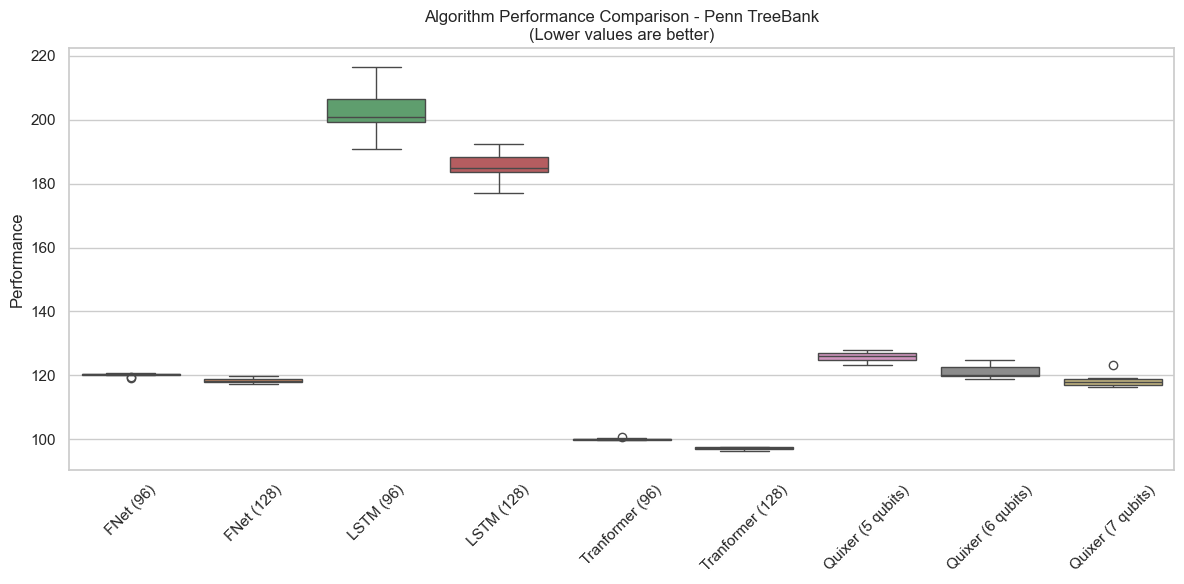

CD = 4.638556208962409


<Figure size 640x480 with 0 Axes>

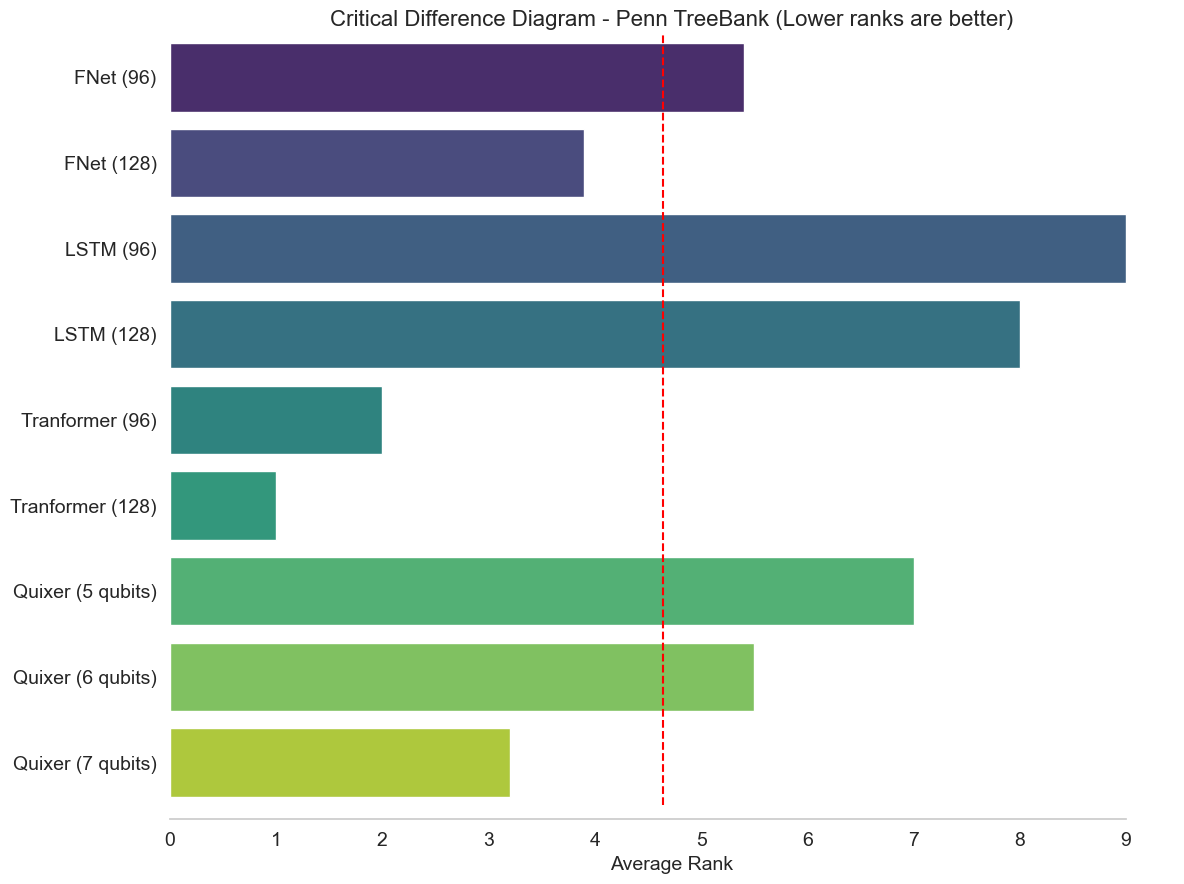

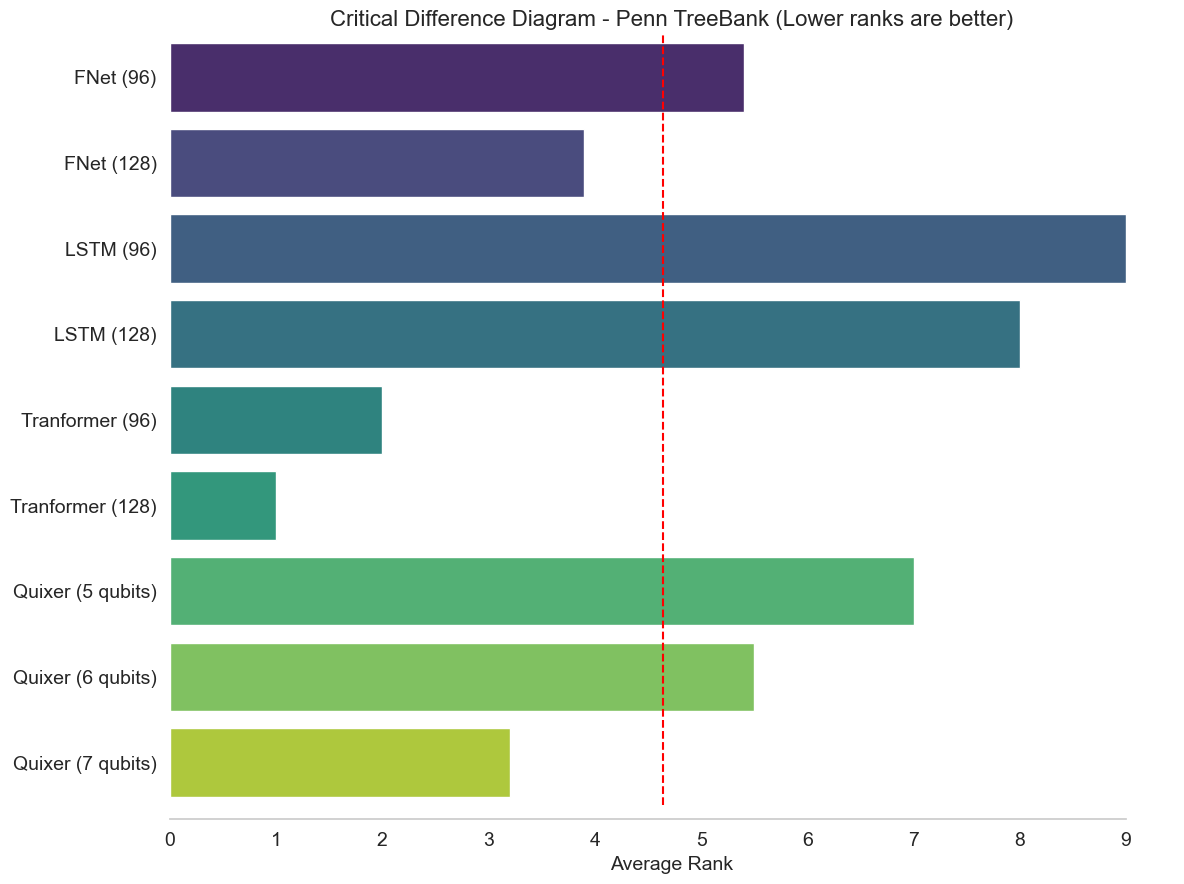

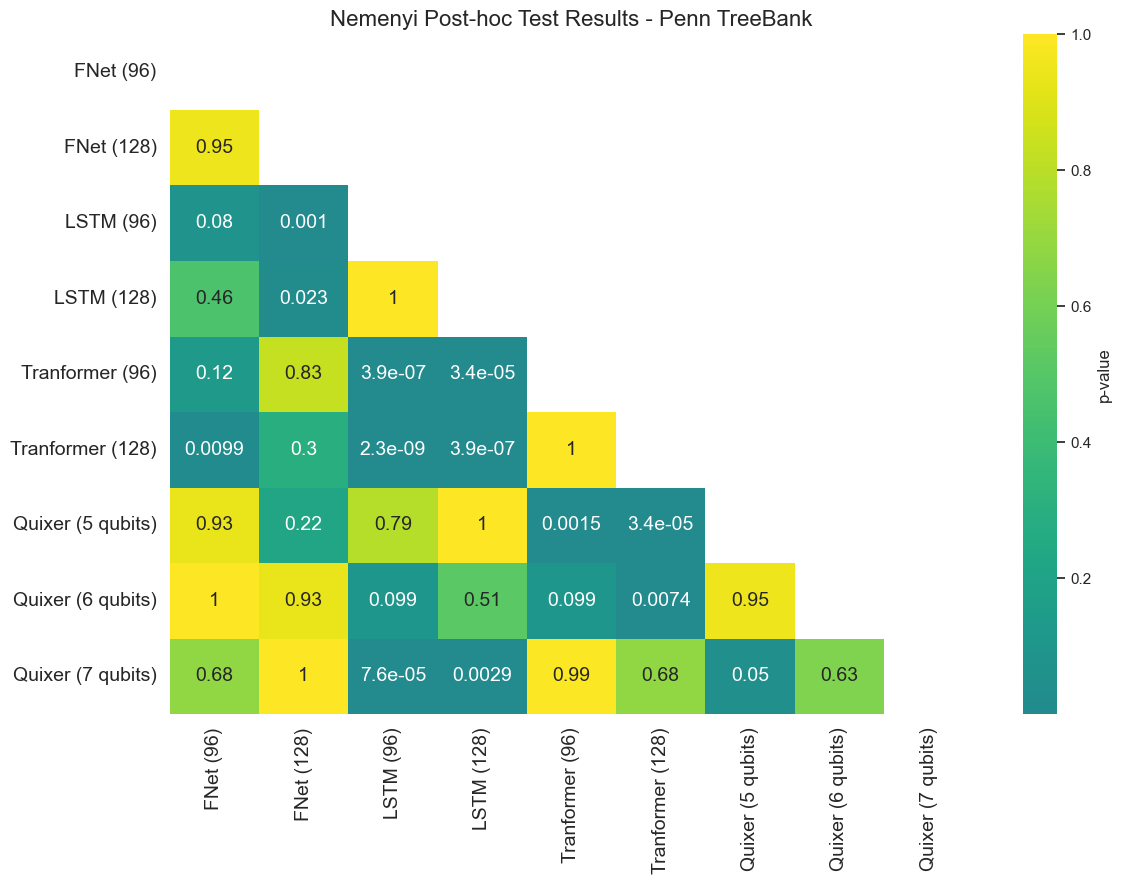


Analysis for WikiText

Best (minimum) values:


FNet (96)            157.739300
FNet (128)           154.534328
LSTM (96)            257.637610
LSTM (128)           232.967738
Tranformer (96)      137.330267
Tranformer (128)     132.975043
Quixer (5 qubits)    190.289084
Quixer (6 qubits)    180.556299
Quixer (7 qubits)    173.323759
dtype: float64


Best performing algorithm:
Tranformer (128) (mean: 133.7014)

Friedman Test Results:
Statistic: 79.7600
P-value: 0.0000

Significant differences found. Performing post-hoc analysis...

Nemenyi Post-hoc Test Results:


,FNet (96),FNet (128),LSTM (96),LSTM (128),Tranformer (96),Tranformer (128),Quixer (5 qubits),Quixer (6 qubits),Quixer (7 qubits)
FNet (96),1.000000,0.996425,1.472234e-03,3.012352e-02,7.867263e-01,2.571750e-01,0.301782,0.737706,0.996425
FNet (128),0.996425,1.000000,3.389951e-05,1.472234e-03,9.964245e-01,7.867263e-01,0.038926,0.216887,0.786726
LSTM (96),0.001472,0.000034,1.000000e+00,9.964245e-01,3.919157e-07,2.334776e-09,0.737706,0.301782,0.030124
LSTM (128),0.030124,0.001472,9.964245e-01,1.000000e+00,3.389951e-05,3.919157e-07,0.993125,0.830958,0.257175
Tranformer (96),0.786726,0.996425,3.919157e-07,3.389951e-05,1.000000e+00,9.964245e-01,0.002063,0.023110,0.257175
Tranformer (128),0.257175,0.786726,2.334776e-09,3.919157e-07,9.964245e-01,1.000000e+00,0.000051,0.001043,0.030124
Quixer (5 qubits),0.301782,0.038926,7.377056e-01,9.931248e-01,2.062649e-03,5.101931e-05,1.000000,0.999276,0.830958
Quixer (6 qubits),0.737706,0.216887,3.017818e-01,8.309581e-01,2.310987e-02,1.042992e-03,0.999276,1.000000,0.993125
Quixer (7 qubits),0.996425,0.786726,3.012352e-02,2.571750e-01,2.571750e-01,3.012352e-02,0.830958,0.993125,1.000000



Hypothesis Rejection DataFrame:


/var/folders/m0/92gfbc6x10s7fdvbqfp73yqh0000gn/T/ipykernel_15604/3628854065.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  rejection_df = post_hoc_results.applymap(lambda p: 'Reject' if p < alpha else 'Fail to Reject')


,FNet (96),FNet (128),LSTM (96),LSTM (128),Tranformer (96),Tranformer (128),Quixer (5 qubits),Quixer (6 qubits),Quixer (7 qubits)
FNet (96),Fail to Reject,Fail to Reject,Reject,Reject,Fail to Reject,Fail to Reject,Fail to Reject,Fail to Reject,Fail to Reject
FNet (128),Fail to Reject,Fail to Reject,Reject,Reject,Fail to Reject,Fail to Reject,Reject,Fail to Reject,Fail to Reject
LSTM (96),Reject,Reject,Fail to Reject,Fail to Reject,Reject,Reject,Fail to Reject,Fail to Reject,Reject
LSTM (128),Reject,Reject,Fail to Reject,Fail to Reject,Reject,Reject,Fail to Reject,Fail to Reject,Fail to Reject
Tranformer (96),Fail to Reject,Fail to Reject,Reject,Reject,Fail to Reject,Fail to Reject,Reject,Reject,Fail to Reject
Tranformer (128),Fail to Reject,Fail to Reject,Reject,Reject,Fail to Reject,Fail to Reject,Reject,Reject,Reject
Quixer (5 qubits),Fail to Reject,Reject,Fail to Reject,Fail to Reject,Reject,Reject,Fail to Reject,Fail to Reject,Fail to Reject
Quixer (6 qubits),Fail to Reject,Fail to Reject,Fail to Reject,Fail to Reject,Reject,Reject,Fail to Reject,Fail to Reject,Fail to Reject
Quixer (7 qubits),Fail to Reject,Fail to Reject,Reject,Fail to Reject,Fail to Reject,Reject,Fail to Reject,Fail to Reject,Fail to Reject


\begin{tabular}{llllllllll}
\toprule
 & FNet (96) & FNet (128) & LSTM (96) & LSTM (128) & Tranformer (96) & Tranformer (128) & Quixer (5 qubits) & Quixer (6 qubits) & Quixer (7 qubits) \\
\midrule
FNet (96) & Fail to Reject & Fail to Reject & Reject & Reject & Fail to Reject & Fail to Reject & Fail to Reject & Fail to Reject & Fail to Reject \\
FNet (128) & Fail to Reject & Fail to Reject & Reject & Reject & Fail to Reject & Fail to Reject & Reject & Fail to Reject & Fail to Reject \\
LSTM (96) & Reject & Reject & Fail to Reject & Fail to Reject & Reject & Reject & Fail to Reject & Fail to Reject & Reject \\
LSTM (128) & Reject & Reject & Fail to Reject & Fail to Reject & Reject & Reject & Fail to Reject & Fail to Reject & Fail to Reject \\
Tranformer (96) & Fail to Reject & Fail to Reject & Reject & Reject & Fail to Reject & Fail to Reject & Reject & Reject & Fail to Reject \\
Tranformer (128) & Fail to Reject & Fail to Reject & Reject & Reject & Fail to Reject & Fail to Reject & Reje

<Figure size 640x480 with 0 Axes>

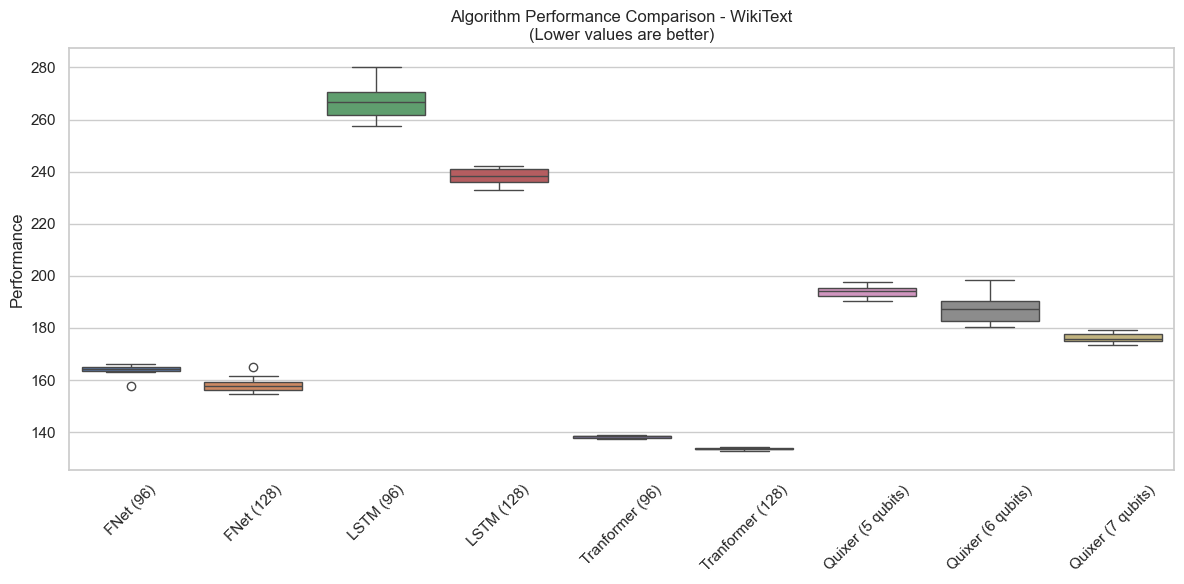

CD = 4.638556208962409


<Figure size 640x480 with 0 Axes>

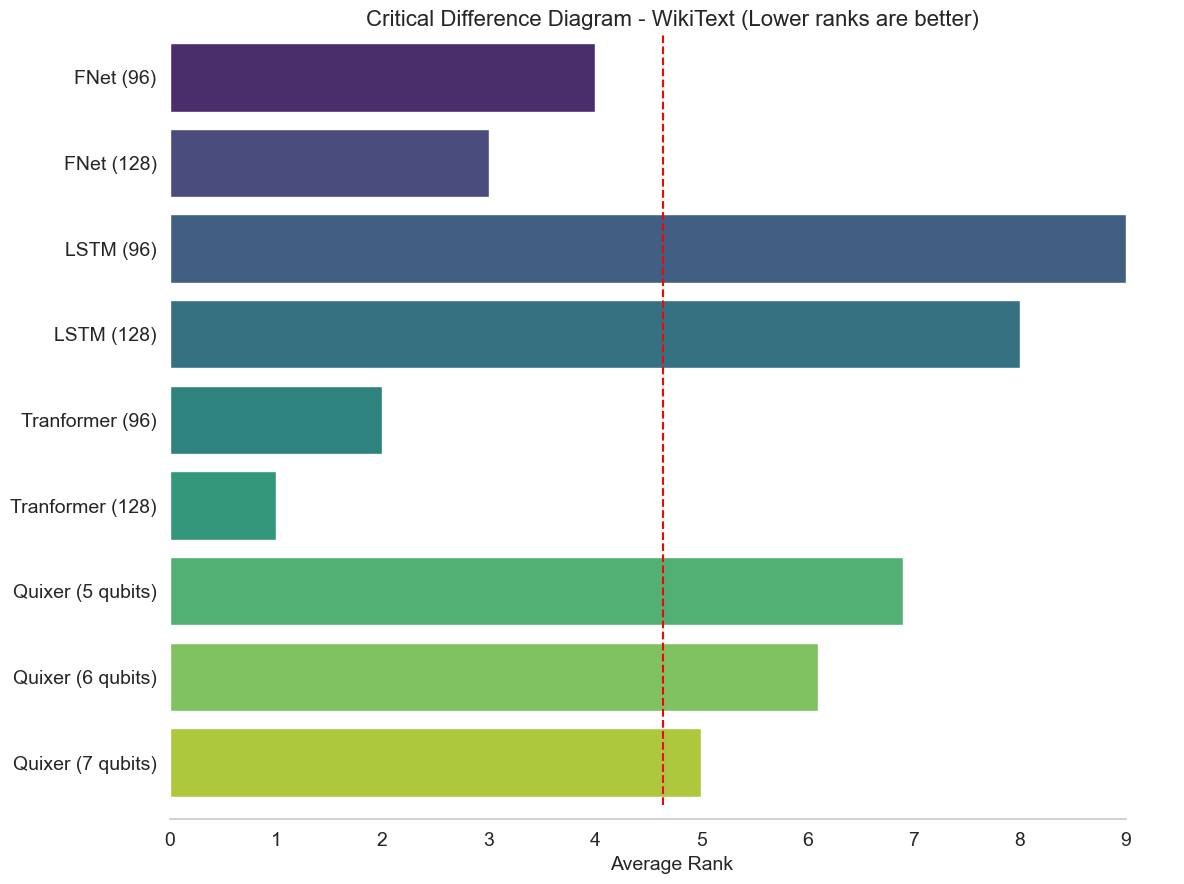

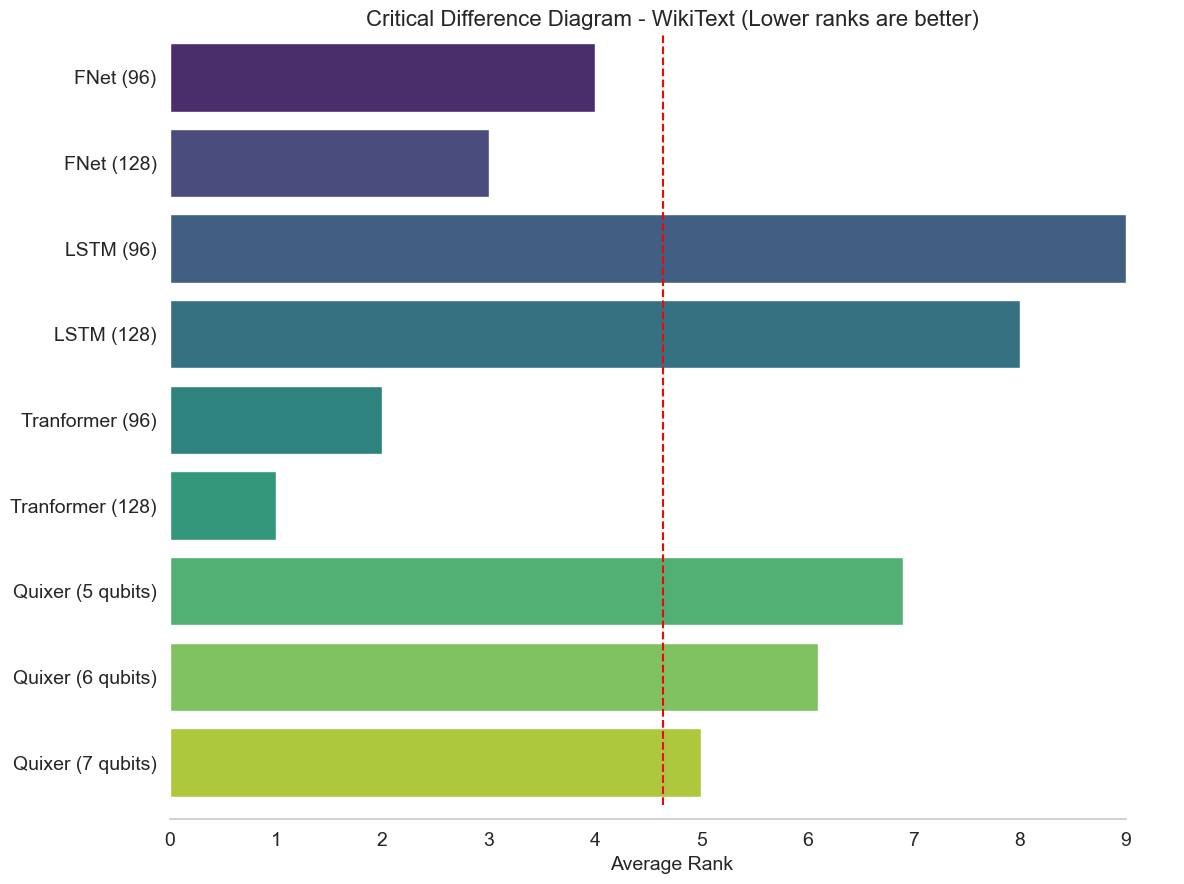

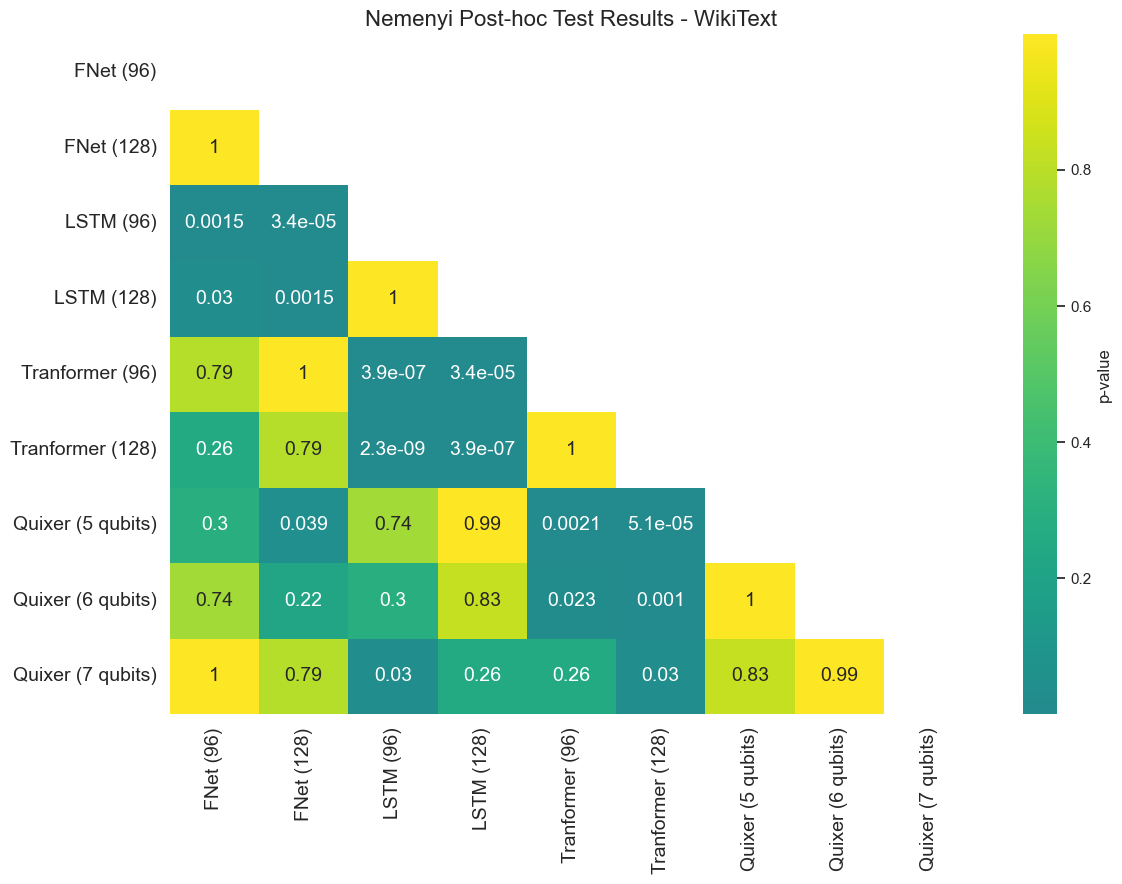

In [5]:
def create_hypothesis_rejection_df(post_hoc_results, alpha=0.05):
    """Create a DataFrame indicating hypothesis rejection for each pair of algorithms"""
    rejection_df = post_hoc_results.applymap(lambda p: 'Reject' if p < alpha else 'Fail to Reject')
    return rejection_df

def analyze_dataset_with_hypothesis(dataset, dataset_name):
    print(f"\nAnalysis for {dataset_name}")
    print("="*50)

    # Basic statistics for minimization problem
    print("\nBest (minimum) values:")
    best_values = dataset.min()
    display(best_values)

    print("\nBest performing algorithm:")
    best_algo = dataset.mean().idxmin()
    print(f"{best_algo} (mean: {dataset[best_algo].mean():.4f})")

    # Friedman test
    statistic, p_value = perform_friedman_test(dataset)
    print(f"\nFriedman Test Results:")
    print(f"Statistic: {statistic:.4f}")
    print(f"P-value: {p_value:.4f}")

    if p_value < 0.05:
        print("\nSignificant differences found. Performing post-hoc analysis...")

        # Nemenyi post-hoc test
        post_hoc_results = posthoc_nemenyi_friedman(dataset)
        print("\nNemenyi Post-hoc Test Results:")
        display(post_hoc_results)

        # Create hypothesis rejection DataFrame
        hypothesis_rejection_df = create_hypothesis_rejection_df(post_hoc_results)
        print("\nHypothesis Rejection DataFrame:")
        # convert hypothesis_rejection_df to a latex table
        display(hypothesis_rejection_df)
        latex_table = hypothesis_rejection_df.to_latex()
        print(latex_table)

        # Create visualizations
        print("\nGenerating visualizations...")

        # 1. Boxplot
        plt.figure()
        boxplot = create_boxplot(dataset, f"Algorithm Performance Comparison - {dataset_name}\n(Lower values are better)")
        plt.show()
        # 2. Critical Difference diagram
        plt.figure()
        cd_diagram = create_cd_diagram(dataset, dataset.columns, f"Critical Difference Diagram - {dataset_name} (Lower ranks are better)")
        cd_diagram.savefig(f"CD-Diagram-{dataset_name}.png", dpi=300, bbox_inches='tight')  # Save the figure
        plt.show()
        # 3. Post-hoc test heatmap
        plt.figure(cd_diagram)
        heatmap = create_heatmap(post_hoc_results, dataset.columns, f"Nemenyi Post-hoc Test Results - {dataset_name}")
        heatmap.savefig(f"Heatmap-{dataset_name}.png", dpi=300, bbox_inches='tight')  # Save the figure
        plt.show()
    else:
        print("\nNo significant differences found between algorithms.")

        # Create boxplot anyway for visualization
        plt.figure()
        boxplot = create_boxplot(dataset, f"Algorithm Performance Comparison - {dataset_name}\n(Lower values are better)")
        plt.show()

# Analyze both datasets with hypothesis rejection DataFrame
analyze_dataset_with_hypothesis(dataset_penn, 'Penn TreeBank')
analyze_dataset_with_hypothesis(dataset_wiki, 'WikiText')






In [6]:
# convert hypothesis_rejection_df to a latex table
latex_table = hypothesis_rejection_df.to_latex()
print(latex_table)


NameError: name 'hypothesis_rejection_df' is not defined